In [135]:
import torch
import torchvision as tv
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn as nn
import cv2
import os
from PIL import Image
import numpy as np
import torch.optim as optim
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
import datetime
from torch.utils.tensorboard import SummaryWriter
# To display tensorboard inside the notebook
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
seed=9 
torch.manual_seed(seed)
if torch.cuda.is_available():
    print("true")
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

true


# Load the data

In [3]:
PATH = "./images_original/"
classes = os.listdir(PATH)

In [4]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [5]:
total_patches = 0
for i in classes:
    PATH2 = "./images_original/"+i
    images = os.listdir(PATH2)
    for j in images:
        total_patches += 1
total_patches

999

In [6]:
data = pd.DataFrame(index=np.arange(0,total_patches),
                   columns= ["image_id","path","label"])

In [7]:
idx = 0
for i in classes:
    PATH2 = "./images_original/"+i
    images = os.listdir(PATH2)
    for j in images:
        final_path = PATH2 + '/'+j
        data.loc[idx,"path"] = final_path
        data.loc[idx,"label"] = i
        data.loc[idx,"image_id"] = idx
        idx += 1

In [8]:
(data.isnull()).sum()

image_id    0
path        0
label       0
dtype: int64

# Encoding of labels

In [9]:
labels = data['label'].unique().tolist()
data['label'] = data['label'].apply(lambda x: labels.index(x))

# spilt the data

In [10]:
#numpy
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    indices = np.random.permutation(data.index)
    train_split = int(train_ratio * data.shape[0])
    val_split = int((train_ratio + val_ratio) * data.shape[0])

    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]

    train_df = data.loc[train_indices]
    val_df = data.loc[val_indices]
    test_df = data.loc[test_indices]

    return train_df, val_df, test_df

In [11]:
train_df, val_df, test_df = train_val_test_split(data)
train_df.shape

(699, 3)

In [12]:
train_df.head(10)

,image_id,path,label
990,990,./images_original/rock/rock00091.png,9
626,626,./images_original/metal/metal00027.png,6
685,685,./images_original/metal/metal00086.png,6
334,334,./images_original/disco/disco00034.png,3
542,542,./images_original/jazz/jazz00042.png,5
604,604,./images_original/metal/metal00005.png,6
935,935,./images_original/rock/rock00036.png,9
768,768,./images_original/pop/pop00069.png,7
482,482,./images_original/hiphop/hiphop00082.png,4
836,836,./images_original/reggae/reggae00037.png,8


In [13]:
train_df.reset_index(drop=True)
test_df.reset_index(drop=True)
val_df.reset_index(drop=True)

,image_id,path,label
0,46,./images_original/blues/blues00046.png,0
1,63,./images_original/blues/blues00063.png,0
2,687,./images_original/metal/metal00088.png,6
3,670,./images_original/metal/metal00071.png,6
4,483,./images_original/hiphop/hiphop00083.png,4
...,...,...,...
195,14,./images_original/blues/blues00014.png,0
196,330,./images_original/disco/disco00030.png,3
197,356,./images_original/disco/disco00056.png,3
198,823,./images_original/reggae/reggae00024.png,8


# data visualization

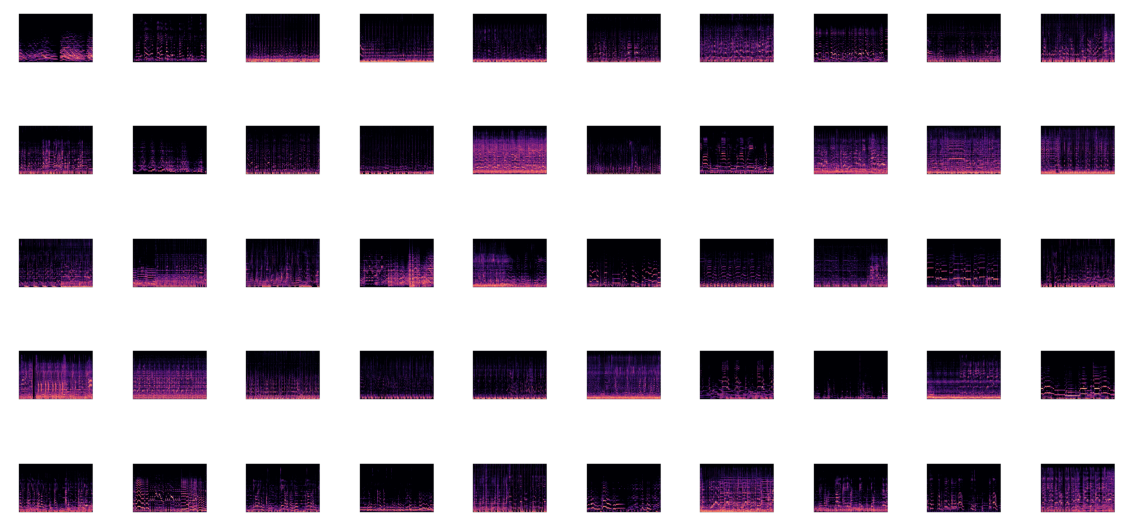

In [14]:
random_selection = np.random.choice(train_df.index.values, size=50, replace=False)
fig, axs = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = random_selection[m + 10*n]
        image = cv2.imread(train_df.loc[idx, "path"])
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[n,m].imshow(image)
        axs[n,m].grid(False)
        axs[n,m].axis("off")

# Resize the image

In [15]:
transform = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor(),
])

# Create custom dataset

In [16]:
class CustomDataset(Dataset):
    
    def __init__(self, df, transform=None):
        super().__init__()
        self.path_label = df
        self.transform = transform
        
    def __len__(self):

        return self.path_label.shape[0]
    
    def __info__(self):
        print("IDC data")
        print("\t Number of Samples: {}".format(self.path_label.shape[0]))
    def __getitem__(self, idx):
        #index : index+1(n:batch_size)
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_id = self.path_label["image_id"].values[idx]
        image_path = self.path_label["path"].values[idx]
        image = Image.open(image_path)
        label = self.path_label["label"].values[idx]
        
        if self.transform:
            #image = Image.fromarray(io.imread(image_path))
            image = self.transform(image)
        
        return image,label

In [17]:
train_df = CustomDataset(train_df,transform=transform)
val_df = CustomDataset(val_df,transform=transform)
test_df = CustomDataset(test_df,transform=transform)

# Load the dataset

In [18]:
train_loader=DataLoader(train_df,batch_size=16,num_workers=0, shuffle=True)
val_loader=DataLoader(val_df,batch_size=16,num_workers=0, shuffle=True)
test_loader=DataLoader(test_df,batch_size=16,num_workers=0, shuffle=True)

In [19]:
itr = iter(train_loader)
b,l = next(itr)
print(b.size())
print(l.size())

torch.Size([16, 4, 180, 180])
torch.Size([16])


In [20]:
def evaluate(loader,model,device):
    with torch.no_grad():
        model.eval()
        total=0.
        for imgs,labels in loader:
            imgs=imgs.to(device)
            labels=labels.to(device)
            outputs=model(imgs)
            _,pred=torch.max(outputs,dim=1)
            total+=(pred==labels).sum()
    return total.item(),(total/len(loader.dataset)).item()

In [21]:
def evaluate_board(dataloader,train_df,model,device):
    total=train_df.__len__()
    with torch.no_grad():
        model.eval()
        correct=0
        for data in dataloader:
            imgs,labels=data
            imgs=imgs.to(device)
            labels=labels.to(device)
            outputs=model(imgs)
            _,predicted=torch.max(outputs.data,1)
            correct+=(predicted==labels).sum()
  

    return (correct/total).item()

In [140]:
def fit(model,criterion,optimizer, batchdata, running_loss,epochs=50,cla=False):
    for epoch in range(epochs):
        pbar = tqdm(batchdata)
        pbar.set_description(f"Epoch:")
        loss_list = []
        epoch_loss=0.
        for data in pbar:
            torch.cuda.empty_cache()
            imgs,labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)
            if cla == True:
                yhat = labels.flatten().long()
            #imgs=imgs.cuda()
            #labels=labels.cuda()
            yhat=model(imgs)
            loss=criterion(yhat,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            final_loss = np.mean(running_loss)
            epoch_loss=0.9*epoch_loss+0.1*loss.item()
        print("loss {:.4f}".format(final_loss))
        t_acc=evaluate_board(train_loader,train_df,model,device) 
        v_acc=evaluate_board(test_loader,test_df,model,device)
        writer.add_scalar("loss",epoch_loss,epoch)
        print()
        writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
        writer.close()

# Fc_network

In [23]:

class Net(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.relu=nn.ReLU()
        self.layer1=nn.Linear(self.in_features,hidden_size1)
        self.layer2=nn.Linear(hidden_size1,hidden_size2)

        self.layer3=nn.Linear(hidden_size2,self.out_features)
    def forward(self,x):
        x=x.flatten(start_dim=1)
        z1=self.layer1(x)
        sigma1=self.relu(z1)
        z2=self.layer2(sigma1)
        sigma2=self.relu(z2)
        z3=self.layer3(sigma2)

        return z3


# Network structure

In [25]:
input_size=4*180*180
hidden_size1=256
hidden_size2=128
output_size=10
itr=iter(train_loader)
imgs,labels=next(itr)
imgs=imgs.to(device)
labels=labels.to(device)
model_fc_relu_50=Net(input_size,output_size).to(device)
output=model_fc_relu_50(imgs)
output.size()

torch.Size([16, 10])

In [26]:
summary(Net(360*360,10),input_size=(64,4,180,180))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [64, 256]                 33,177,856
├─ReLU: 1-2                              [64, 256]                 --
├─Linear: 1-3                            [64, 128]                 32,896
├─ReLU: 1-4                              [64, 128]                 --
├─Linear: 1-5                            [64, 10]                  1,290
Total params: 33,212,042
Trainable params: 33,212,042
Non-trainable params: 0
Total mult-adds (G): 2.13
Input size (MB): 33.18
Forward/backward pass size (MB): 0.20
Params size (MB): 132.85
Estimated Total Size (MB): 166.23

# when epoch is 50

In [141]:
epochs=50
model_fc_relu_50=Net(input_size,output_size).to(device)
#optimizer=optim.SGD(model_fc_relu_50.parameters(),lr=0.001)
optimizer=optim.Adam(model_fc_relu_50.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net'
writer=SummaryWriter(log_dir)
fit(model_fc_relu_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)


  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3388



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2261



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1861



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1528



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1268



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1007



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0779



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0583



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0390



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0228



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0044



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9854



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9653



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9481



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9301



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9163



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8964



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8798



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8656



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8492



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8341



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8157



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7986



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7816



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7663



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7499



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7337



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7174



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7024



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6876



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6753



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6605



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6452



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6300



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6160



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6012



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5883



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5744



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5612



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5469



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5322



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5180



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5050



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4939



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4811



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4679



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4549



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4421



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4290



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4163



# Evaluate the network

In [48]:
evaluate_board(train_loader,train_df,model_fc_relu_50,device=device)

0.8125894069671631

In [49]:
evaluate(test_loader,model_fc_relu_50,device)

(52.0, 0.5199999809265137)

In [50]:
evaluate(val_loader,model_fc_relu_50,device)

(97.0, 0.48499998450279236)

# FCN using sigmoid

In [51]:
class Net_sigmoid(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.sigmoid=nn.Sigmoid()
        self.in_features = in_features
        self.out_features = out_features
        self.layer1=nn.Linear(self.in_features,hidden_size1)
        self.layer2=nn.Linear(hidden_size1,hidden_size2)

        self.layer3=nn.Linear(hidden_size2,self.out_features)
    def forward(self,x):
        x=x.flatten(start_dim=1)
        z1=self.layer1(x)
        sigma1=self.sigmoid(z1)
        z2=self.layer2(sigma1)
        sigma2=self.sigmoid(z2)
        z3=self.layer3(sigma2)
#         sigma3 = F.softmax(z3,dim=1)

        return z3

In [52]:
epochs=50
model_fc_sigmoid_50=Net_sigmoid(input_size,output_size).to(device)
optimizer=optim.SGD(model_fc_sigmoid_50.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_sigmoid'
writer=SummaryWriter(log_dir)
fit(model_fc_sigmoid_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)


  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3294



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3240



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3202



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3173



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3151



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3132



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3117



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3105



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3095



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3086



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3078



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3071



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3065



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3060



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3055



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3050



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3046



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3042



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3039



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3035



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3032



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3029



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3027



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3024



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3021



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3019



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3016



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3014



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3011



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3009



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3007



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3004



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3002



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3000



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2998



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2996



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2994



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2992



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2990



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2988



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2986



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2984



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2982



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2980



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2978



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2976



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2974



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2972



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2970



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2968



# Evaluate the network

In [53]:
evaluate_board(train_loader,train_df,model_fc_sigmoid_50,device=device)

0.13018597662448883

In [54]:
evaluate(test_loader,model_fc_sigmoid_50,device)

(9.0, 0.08999999612569809)

In [55]:
evaluate(val_loader,model_fc_sigmoid_50,device)

(20.0, 0.09999999403953552)

In [134]:
%tensorboard --logdir logs/tensorboard

Reusing TensorBoard on port 6006 (pid 86280), started 14:27:31 ago. (Use '!kill 86280' to kill it.)

# when epoch is 100

In [58]:
epochs=100
model_fc_relu_100 = Net(input_size,output_size).to(device)
#optimizer=optim.SGD(model_fc_relu_100.parameters(),lr=0.001)
optimizer=optim.Adam(model_fc_relu_100.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_100'
writer=SummaryWriter(log_dir)
fit(model_fc_relu_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)


  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3586



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2461



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1954



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1615



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1235



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0993



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0789



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0580



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0305



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0084



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9865



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9658



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9478



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9317



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9139



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8941



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8746



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8557



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8351



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8152



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7957



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7791



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7623



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7444



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7307



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7151



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6993



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6837



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6689



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6542



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6414



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6262



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6118



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5962



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5823



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5675



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5540



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5391



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5251



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5107



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4968



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4843



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4706



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4564



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4435



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4305



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4167



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4029



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3908



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3782



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3657



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3521



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3401



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3284



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3158



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3038



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2909



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2778



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2652



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2532



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2411



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2285



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2163



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2054



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1941



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1822



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1704



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1593



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1483



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1371



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1261



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1154



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1050



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0952



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0844



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0735



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0635



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0533



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0432



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0332



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0237



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0147



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0056



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9961



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9870



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9788



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9702



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9618



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9527



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9440



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9352



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9267



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9183



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9099



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9017



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8939



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8859



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8780



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8704



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8629



# Evaluate the network 

In [59]:
evaluate_board(train_loader,train_df,model_fc_relu_100,device=device)

0.9971387982368469

In [60]:
evaluate(test_loader,model_fc_relu_100,device)

(51.0, 0.5099999904632568)

In [61]:
evaluate(val_loader,model_fc_relu_100,device)

(92.0, 0.4599999785423279)

In [62]:
epochs=100
model_fc_sigmoid_100 = Net_sigmoid(input_size,output_size).to(device)
optimizer=optim.SGD(model_fc_sigmoid_100.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_sigmoid_100'
writer=SummaryWriter(log_dir)
fit(model_fc_sigmoid_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)


  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3668



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3552



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3469



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3402



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3351



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3310



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3277



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3249



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3226



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3206



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3189



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3175



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3162



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3151



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3141



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3132



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3124



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3117



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3110



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3104



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3098



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3093



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3088



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3084



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3080



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3075



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3072



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3068



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3065



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3062



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3058



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3055



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3053



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3050



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3047



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3045



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3042



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3040



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3037



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3035



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3033



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3030



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3028



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3026



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3024



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3022



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3020



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3018



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3016



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3014



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3012



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3010



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3008



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3006



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3004



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3002



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3001



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2999



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2997



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2995



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2993



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2992



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2990



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2988



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2986



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2985



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2983



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2981



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2979



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2977



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2976



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2974



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2972



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2971



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2969



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2967



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2965



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2964



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2962



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2960



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2958



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2957



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2955



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2953



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2951



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2950



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2948



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2946



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2944



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2943



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2941



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2939



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2937



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2935



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2934



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2932



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2930



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2928



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2926



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2925



In [63]:
evaluate_board(train_loader,train_df,model_fc_sigmoid_100,device=device)

0.18884120881557465

In [64]:
evaluate(test_loader,model_fc_sigmoid_100,device)

(15.0, 0.14999999105930328)

In [65]:
evaluate(val_loader,model_fc_sigmoid_100,device)

(33.0, 0.16499999165534973)

# Convolutional network

In [66]:
class Net2(nn.Module):
    def __init__(self,in_channels=4,out_channels=10):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(self.in_channels, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.conv3 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 45 * 45,256)
        self.fc2 = nn.Linear(256,self.out_channels)
        
        
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        output = self.fc2(x)
        
        return output
        
        
    

# Nextword structure

In [67]:
from torchinfo import summary

In [68]:
summary(Net2(),input_size=(64,4,180,180),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     --                        --
├─Conv2d: 1-1                            [64, 64, 180, 180]        2,368
├─ReLU: 1-2                              [64, 64, 180, 180]        --
├─Conv2d: 1-3                            [64, 128, 180, 180]       73,856
├─ReLU: 1-4                              [64, 128, 180, 180]       --
├─MaxPool2d: 1-5                         [64, 128, 90, 90]         --
├─Conv2d: 1-6                            [64, 64, 90, 90]          73,792
├─ReLU: 1-7                              [64, 64, 90, 90]          --
├─Conv2d: 1-8                            [64, 32, 90, 90]          18,464
├─ReLU: 1-9                              [64, 32, 90, 90]          --
├─MaxPool2d: 1-10                        [64, 32, 45, 45]          --
├─Linear: 1-11                           [64, 256]                 16,589,056
├─Linear: 1-12                           [64, 10]             

# When epoch is 50

In [70]:
epochs=50
model_net2_50=Net2().to(device)
#optimizer=optim.SGD(model_net2_50.parameters(),lr=0.001)
optimizer=optim.Adam(model_net2_50.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_cnn_50'
writer=SummaryWriter(log_dir)
fit(model_net2_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3130



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2513



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1753



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1104



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0544



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9977



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9538



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9068



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8580



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8098



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7612



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7156



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6696



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6292



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5807



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5373



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4901



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4446



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3948



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3479



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3048



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2638



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2192



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1750



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1330



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0925



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0542



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0175



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9832



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9510



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9208



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8923



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8655



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8402



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8164



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7939



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7725



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7522



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7330



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7148



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6974



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6808



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6650



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6499



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6355



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6217



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6085



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5959



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5837



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5721



# Evaluate the network

In [71]:
evaluate_board(train_loader,train_df,model_net2_50,device=device)

1.0

In [72]:
evaluate(test_loader,model_net2_50,device)

(53.0, 0.5299999713897705)

In [73]:
evaluate(val_loader,model_net2_50,device)

(109.0, 0.5450000166893005)

In [74]:
class Net2_teach(nn.Module):
    def __init__(self,in_channels=4,out_channels=10):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(self.in_channels, out_channels=32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(42*42*64,256)
        self.fc2 = nn.Linear(256,self.out_channels)
        
        
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        output = self.fc2(x)
        
        return output

In [75]:
summary(Net2_teach(),input_size=(64,4,180,180),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net2_teach                               --                        --
├─Conv2d: 1-1                            [64, 32, 178, 178]        1,184
├─ReLU: 1-2                              [64, 32, 178, 178]        --
├─Conv2d: 1-3                            [64, 32, 176, 176]        9,248
├─ReLU: 1-4                              [64, 32, 176, 176]        --
├─MaxPool2d: 1-5                         [64, 32, 88, 88]          --
├─Conv2d: 1-6                            [64, 64, 86, 86]          18,496
├─ReLU: 1-7                              [64, 64, 86, 86]          --
├─Conv2d: 1-8                            [64, 64, 84, 84]          36,928
├─ReLU: 1-9                              [64, 64, 84, 84]          --
├─MaxPool2d: 1-10                        [64, 64, 42, 42]          --
├─Linear: 1-11                           [64, 256]                 28,901,632
├─Linear: 1-12                           [64, 10]              

In [77]:
epochs=50
model_net2_teach_50=Net2_teach().to(device)
#optimizer=optim.SGD(model_net2_teach_50.parameters(),lr=0.001)
optimizer=optim.Adam(model_net2_teach_50.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_cnnteach_50'
writer=SummaryWriter(log_dir)
fit(model_net2_teach_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2806



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1793



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1012



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0298



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9609



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8914



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8205



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7391



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6657



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5851



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5003



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4189



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3397



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2628



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1904



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1241



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0619



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0059



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9547



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9078



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8652



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8263



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7907



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7580



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7279



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7000



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6742



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6502



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6279



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6070



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5875



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5692



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5520



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5358



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5205



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5060



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4924



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4795



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4672



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4555



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4444



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4338



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4238



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4141



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4049



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3961



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3877



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3797



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3719



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3645



# Evaluate the network

In [78]:
evaluate_board(train_loader,train_df,model_net2_teach_50,device=device)

1.0

In [79]:
evaluate(test_loader,model_net2_teach_50,device)

(56.0, 0.5600000023841858)

In [80]:
evaluate(val_loader,model_net2_teach_50,device)

(105.0, 0.5249999761581421)

# When epoch is 100

In [81]:
epochs=100
model_net2_100=Net2().to(device)
#optimizer=optim.SGD(model_net2_100.parameters(),lr=0.001)
optimizer=optim.Adam(model_net2_100.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_cnn_100'
writer=SummaryWriter(log_dir)
fit(model_net2_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3052



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2429



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1735



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1115



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0556



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0083



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9611



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9161



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8676



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8165



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7672



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7179



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6676



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6174



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5656



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5131



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4647



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4128



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3626



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3141



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2666



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2197



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1746



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1307



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0891



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0496



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0123



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9773



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9444



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9135



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8844



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8570



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8313



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8069



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7840



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7623



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7418



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7223



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7038



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6863



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6696



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6537



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6385



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6240



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6102



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5969



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5843



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5721



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5605



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5493



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5385



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5282



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5182



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5086



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4994



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4905



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4819



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4736



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4656



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4578



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4503



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4430



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4360



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4292



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4226



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4162



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4100



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4040



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3981



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3924



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3869



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3815



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3763



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3712



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3663



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3615



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3568



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3522



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3477



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3434



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3391



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3350



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3310



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3270



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3232



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3194



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3158



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3122



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3087



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3052



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3019



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2986



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2954



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2922



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2892



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2862



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2832



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2803



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2775



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2747



# Evaluate the network

In [82]:
evaluate_board(train_loader,train_df,model_net2_100,device=device)

1.0

In [83]:
evaluate(test_loader,model_net2_100,device)

(57.0, 0.5699999928474426)

In [84]:
evaluate(val_loader,model_net2_100,device)

(110.0, 0.550000011920929)

In [130]:
epochs=100
model_net2_teach_100=Net2_teach().to(device)
#optimizer=optim.SGD(model_net2_teach_100.parameters(),lr=0.001)
optimizer=optim.Adam(model_net2_teach_100.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_cnnteach_100'
writer=SummaryWriter(log_dir)
fit(model_net2_teach_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2758



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1716



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0886



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0261



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9572



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8898



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8170



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7440



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6704



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5950



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5225



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4514



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3818



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3140



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2490



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1868



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1287



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0738



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0243



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9763



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9320



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8910



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8534



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8187



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7865



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7566



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7289



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7031



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6790



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6566



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6355



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6158



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5972



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5797



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5632



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5476



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5329



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5189



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5056



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4930



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4810



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4696



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4587



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4483



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4383



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4288



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4197



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4110



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4026



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3946



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3868



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3794



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3722



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3654



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3587



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3523



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3461



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3402



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3344



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3288



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3235



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3182



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3132



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3083



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3036



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2990



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2945



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2902



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2860



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2819



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2779



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2741



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2703



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2666



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2631



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2596



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2563



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2530



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2498



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2467



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2436



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2406



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2377



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2349



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2321



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2294



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2268



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2242



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2217



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2192



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2168



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2145



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2122



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2099



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2077



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2055



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2034



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2014



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1993



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1973



# Evaluate the network

In [131]:
evaluate_board(train_loader,train_df,model_net2_teach_100,device=device)

1.0

In [132]:
evaluate(test_loader,model_net2_teach_100,device)

(62.0, 0.6200000047683716)

In [133]:
evaluate(val_loader,model_net2_teach_100,device)

(101.0, 0.5049999952316284)

# Convolutional network with normalisation layer

In [97]:
class Net3(nn.Module):
    def __init__(self,in_channels=4,out_channels=10):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(self.in_channels, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.conv3 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 45 * 45,256)
        self.fc2 = nn.Linear(256,self.out_channels)
        
    def forward(self,x):
        x = F.tanh(self.conv1(x))
        x = self.bn(x)
        x = F.tanh(self.conv2(x))
        x = self.pool1(x)
        x = F.tanh(self.conv3(x))
        x = F.tanh(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        output = self.fc2(x)
        
        return output

# When epoch is 50

In [104]:
epochs=50
model_net3_50=Net3().to(device)
#optimizer=optim.SGD(model_net3_50.parameters(),lr=0.001)
optimizer=optim.Adam(model_net3_50.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_BN_50'
writer=SummaryWriter(log_dir)
fit(model_net3_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\dell\anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss 2.1655



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9063



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6791



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5215



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3979



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2874



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1800



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0766



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9831



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8999



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8282



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7643



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7082



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6594



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6166



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5789



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5454



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5156



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4889



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4647



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4428



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4229



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4047



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3880



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3726



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3584



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3452



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3330



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3216



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3110



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3010



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2916



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2829



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2746



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2668



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2594



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2524



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2458



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2395



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2336



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2279



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2225



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2173



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2124



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2077



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2032



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1989



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1948



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1908



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1870



In [105]:
evaluate_board(train_loader,train_df,model_net3_50,device=device)

1.0

In [106]:
evaluate(test_loader,model_net3_50,device)

(68.0, 0.6800000071525574)

In [107]:
evaluate(val_loader,model_net3_50,device)

(122.0, 0.6100000143051147)

# When epoch is 100

In [121]:
epochs=100
model_net3_100=Net3().to(device)
#optimizer=optim.SGD(model_net_100.parameters(),lr=0.001)
optimizer=optim.Adam(model_net3_100.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_BN_100'
writer=SummaryWriter(log_dir)
fit(model_net3_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1827



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9576



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7879



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6354



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5004



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3612



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2327



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1165



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0143



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9231



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8455



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7787



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7206



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6703



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6265



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5880



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5539



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5235



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4963



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4717



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4495



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4292



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4107



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3938



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3781



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3637



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3503



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3379



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3263



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3155



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3054



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2959



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2870



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2786



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2706



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2631



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2561



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2494



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2430



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2369



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2312



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2257



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2205



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2155



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2107



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2061



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.2018



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1976



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1936



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1897



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1860



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1824



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1790



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1757



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1725



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1694



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1665



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1636



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1608



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1582



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1556



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1531



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1506



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1483



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1460



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1438



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1417



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1396



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1376



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1356



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1337



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1318



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1300



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1283



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1266



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1249



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1233



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1217



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1202



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1187



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1172



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1158



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1144



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1130



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1117



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1104



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1091



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1079



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1067



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1055



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1043



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1032



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1021



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1010



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.1000



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.0989



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.0979



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.0969



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.0959



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.0950



# Evaluate the network

In [122]:
evaluate_board(train_loader,train_df,model_net3_100,device=device)

1.0

In [123]:
evaluate(test_loader,model_net3_100,device)

(66.0, 0.6599999666213989)

In [124]:
evaluate(val_loader,model_net3_100,device)

(122.0, 0.6100000143051147)

# Using RMSprop

# When epoch is 50

In [113]:
epochs=50
model_rmsprop_50=Net3().to(device)
optimizer = torch.optim.RMSprop(model_rmsprop_50.parameters(), lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_RMSprop_50'
writer=SummaryWriter(log_dir)
fit(model_rmsprop_50,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

loss 13.0062



  0%|          | 0/44 [00:00<?, ?it/s]

loss 7.5311



  0%|          | 0/44 [00:00<?, ?it/s]

loss 5.6380



  0%|          | 0/44 [00:00<?, ?it/s]

loss 4.6326



  0%|          | 0/44 [00:00<?, ?it/s]

loss 4.0047



  0%|          | 0/44 [00:00<?, ?it/s]

loss 3.5665



  0%|          | 0/44 [00:00<?, ?it/s]

loss 3.2343



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.9721



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.7544



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.5798



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.4053



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2565



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2856



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.1543



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0337



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9237



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8234



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7295



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6440



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5652



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4933



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4267



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3654



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3090



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2570



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2089



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1643



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1228



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2390



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2103



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1722



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1360



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1020



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0699



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0396



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0109



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9838



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9580



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9336



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9103



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8882



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9418



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9203



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8997



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8799



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8609



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8427



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8253



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8085



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7924



# Evaluate the network

In [114]:
evaluate_board(train_loader,train_df,model_rmsprop_50,device=device)

1.0

In [115]:
evaluate(test_loader,model_rmsprop_50,device)

(62.0, 0.6200000047683716)

In [116]:
evaluate(val_loader,model_rmsprop_50,device)

(119.0, 0.5949999690055847)

# When epoch is 100

In [125]:
epochs=100
model_rmsprop_100=Net3().to(device)
optimizer = torch.optim.RMSprop(model_rmsprop_100.parameters(), lr=0.0001)
criterion=nn.CrossEntropyLoss()
running_loss=[]
log_dir = 'logs/tensorboard/' + 'Net_RMSprop_100'
writer=SummaryWriter(log_dir)
fit(model_rmsprop_100,criterion,optimizer,batchdata=train_loader,running_loss=running_loss,epochs=epochs,cla=True)

  0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\dell\anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss 10.3639



  0%|          | 0/44 [00:00<?, ?it/s]

loss 6.2412



  0%|          | 0/44 [00:00<?, ?it/s]

loss 4.7428



  0%|          | 0/44 [00:00<?, ?it/s]

loss 3.9393



  0%|          | 0/44 [00:00<?, ?it/s]

loss 3.4342



  0%|          | 0/44 [00:00<?, ?it/s]

loss 3.0711



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.7865



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.5604



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.3818



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.2238



  0%|          | 0/44 [00:00<?, ?it/s]

loss 2.0722



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9382



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.9266



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.8087



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.7010



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.6039



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.5157



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.4351



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3616



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2949



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.3468



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2905



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.2365



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1864



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.1399



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0968



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0567



  0%|          | 0/44 [00:00<?, ?it/s]

loss 1.0194



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9845



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9520



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9215



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9169



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.9189



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8923



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8671



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8433



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.8207



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7992



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7789



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7595



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7411



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7235



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.7067



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6907



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6754



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6607



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6467



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6332



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6203



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.6079



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5960



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5845



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5735



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5629



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5527



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5428



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5844



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5756



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5659



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5565



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5474



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5385



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5300



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5218



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5137



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.5060



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4984



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4911



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4840



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4771



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4704



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4639



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4575



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4513



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4453



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4395



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4338



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4282



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4228



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4175



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4123



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4073



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4394



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4343



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4292



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4242



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4194



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4146



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4100



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4054



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.4010



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3966



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3924



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3882



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3841



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3801



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3762



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3724



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3686



  0%|          | 0/44 [00:00<?, ?it/s]

loss 0.3649



In [126]:
evaluate_board(train_loader,train_df,model_rmsprop_100,device=device)

1.0

In [127]:
evaluate(test_loader,model_rmsprop_100,device)

(65.0, 0.6499999761581421)

In [128]:
evaluate(val_loader,model_rmsprop_100,device)

(119.0, 0.5949999690055847)